In [186]:
import collections
import json
import os
import re

import ahocorasick
import openai
import pdfplumber

dataDir = "../data/"
dataName = "Deep Learning.pdf"

# 设置 api


In [187]:
# openai.api_base = "https://api.chatanywhere.com.cn/"
openai.api_base = "https://api.chatanywhere.cn/"
openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"

# 一，读取数据


## 生成目录架构

- 生成**章节名称**与**章节序号**的对应：`name_dict`
- 以及**章节序号**与**章节页码**范围的对应：`index_dict`


In [188]:
with pdfplumber.open(dataDir + dataName) as f:
    # 目录架构生成
    c, p, n = [], [], []
    for i in range(7):
        page = f.pages[i]
        text = page.extract_text()
        text_split = text.split("\n")
        for i in text_split:
            if bool(re.match("[0-9]+\.[0-9]+", i.split(" ")[0])):
                c.append(i.split(" ")[0])
                p.append(i.split(" ")[-1])
            if bool(re.match("[0-9]+", i.split(" ")[0])):
                for j in i.split(" "):
                    if bool(re.match("[A-Za-z]+", j)):
                        n.append((i.split(" ")[0], j))

### name_dict


In [189]:
name_dict = {}
for i, j in n:
    if i in name_dict:
        name_dict[i] = name_dict.get(i, "") + " " + j
    else:
        name_dict[i] = name_dict.get(i, "") + j

### index_dict


In [190]:
p_range = list(zip(p, p[1:]))
p_range.append((720, 800))
c_p_range = list(zip(c, p_range))
index_dict = collections.defaultdict(list)
for k, v in c_p_range:
    index_dict[k.split(".")[0]].append((k, v))

## 生成内容表

- 段落内容表：`content_dict`


### content_dict

In [191]:
with pdfplumber.open(dataDir + dataName) as f:
    content_dict = collections.defaultdict(list)

    for k, v in index_dict.items():
        for i in v:
            page_range = i[-1]

            for j in range(int(page_range[0]), int(page_range[1])):
                page = f.pages[j]

                text = page.extract_text().replace("\n", " ")

                content_dict[i[0]].append(text)

# 二，Build Relations

## 目录 + 前置

In [192]:
def catalogue_relations(dataName, name_dict=None, relation_type=["目录", "前置"]):
    c_relations = []
    p_relations = []
    if not name_dict:
        name_dict = {}
    for k, v in name_dict.items():
        if bool(re.match("[0-9]+\.[0-9]+", k)):
            p_relations.append(
                [
                    k.split(".")[0] + " " + name_dict[k.split(".")[0]],
                    relation_type[1],
                    k + " " + v,
                ]
            )
        else:
            c_relations.append(
                [
                    dataName,
                    relation_type[0],
                    k + " " + v,
                ]
            )
    return p_relations, c_relations

In [193]:
p_relations, c_relations = catalogue_relations(
    dataName=dataName.split(".")[0], name_dict=name_dict
)

## 包含 + 段落共现

### AC自动机

In [194]:
def build(patterns):
    trie = ahocorasick.Automaton()
    for index, word in enumerate(patterns):
        trie.add_word(word, (index, word))
    trie.make_automaton()
    return trie

### 读取关系

In [195]:
data = []
for i in range(1, 21):
    with open(dataDir + "relations/" + "kb_chapter_" + str(i) + ".json", "r") as f:
        data.append([i, json.load(f)])

### 实体清理 

In [196]:
not_use_entity_set = {'man', 'male', 'woman', '8½'}
not_use_relation_set = {'located in the administrative territorial entity'}

In [197]:
semantic_set = set()
for i in data:
    for j in i[1]:
        if (
            not bool(re.match("^([0-9]+|[A-Za-z])$", j[0]))
            and not bool(re.match("^([0-9]+|[A-Za-z])$", j[2]))
            and j[0] != j[2]
            and j[0] not in not_use_entity_set
            and j[1] not in not_use_relation_set
            and j[2] not in not_use_entity_set
        ):
            if j[1] == 'uses': j[1] = 'use'
            semantic_set.add(tuple(j))

In [198]:
len(semantic_set)

439

### 实体提取

In [199]:
entity_set = set()
relation_set = set()
for relation in semantic_set:
    if relation[0] not in entity_set:
        entity_set.add(relation[0])
    if relation[2] not in entity_set:
        entity_set.add(relation[2])
    if relation[1] not in relation_set:
        relation_set.add(relation[1])

In [200]:
len(entity_set)

268

In [201]:
len(relation_set)

27

### 结构关系抽取

In [202]:
def include_co_presence(entity_set):
    patterns = list(entity_set)
    trie = build(patterns)
    include_relations = []
    co_presence_relations = set()
    for chapter, sections in index_dict.items():
        for section in sections:
            for content in content_dict[section[0]]:
                word_set = set(word[1][1] for word in trie.iter(content))
                for head in word_set:
                    if not bool(re.match("^(\d+|[A-Za-z])$", head)):
                        include_relations.append(
                            [section[0] + " " + name_dict[section[0]], "include", head]
                        )
                        for tail in word_set:
                            if head != tail and not bool(
                                re.match("^(\d+|[A-Za-z])$", tail)
                            ):
                                if (
                                    tail,
                                    "co_presence",
                                    head,
                                ) not in co_presence_relations:
                                    co_presence_relations.add(
                                        (head, "co_presence", tail)
                                    )
    return include_relations, co_presence_relations

In [203]:
include_relations, co_presence_relations = include_co_presence(entity_set)

## 结果展示

In [204]:
p_relations[0]

['1 Introduction', '前置', '1.1 Who Should Read This Book?']

In [205]:
c_relations[0]

['Deep Learning', '目录', '1 Introduction']

In [206]:
len(co_presence_relations)

1471

In [207]:
include_relations[0]

['1.1 Who Should Read This Book?', 'include', 'Learning']

In [208]:
structure_relations = (
    p_relations + c_relations + list(co_presence_relations) + include_relations
)

In [209]:
len(structure_relations)

3035

# 三，储存数据

In [210]:
with open(os.path.join(dataDir + "/relations", f"semantic_relations.json"), "w") as f:
    json.dump(list(semantic_set), f, indent=4)

In [211]:
with open(os.path.join(dataDir + "/relations", f"structure_relations.json"), "w") as f:
    json.dump(structure_relations, f, indent=4)

# 四，测试

## 绘制图谱

In [212]:
len(entity_set)

268

In [213]:
test_set = set()
for i in include_relations:
    test_set.add(i[0])
    test_set.add(i[1])
len(test_set)

135

In [214]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

### 整理数据

In [215]:
kg_df = pd.DataFrame(structure_relations, columns=['head', 'relation', 'tail'])

In [216]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df[(kg_df['relation']=='目录')], "head", "tail", edge_attr=True, create_using=nx.MultiDiGraph())  

### 输出图谱

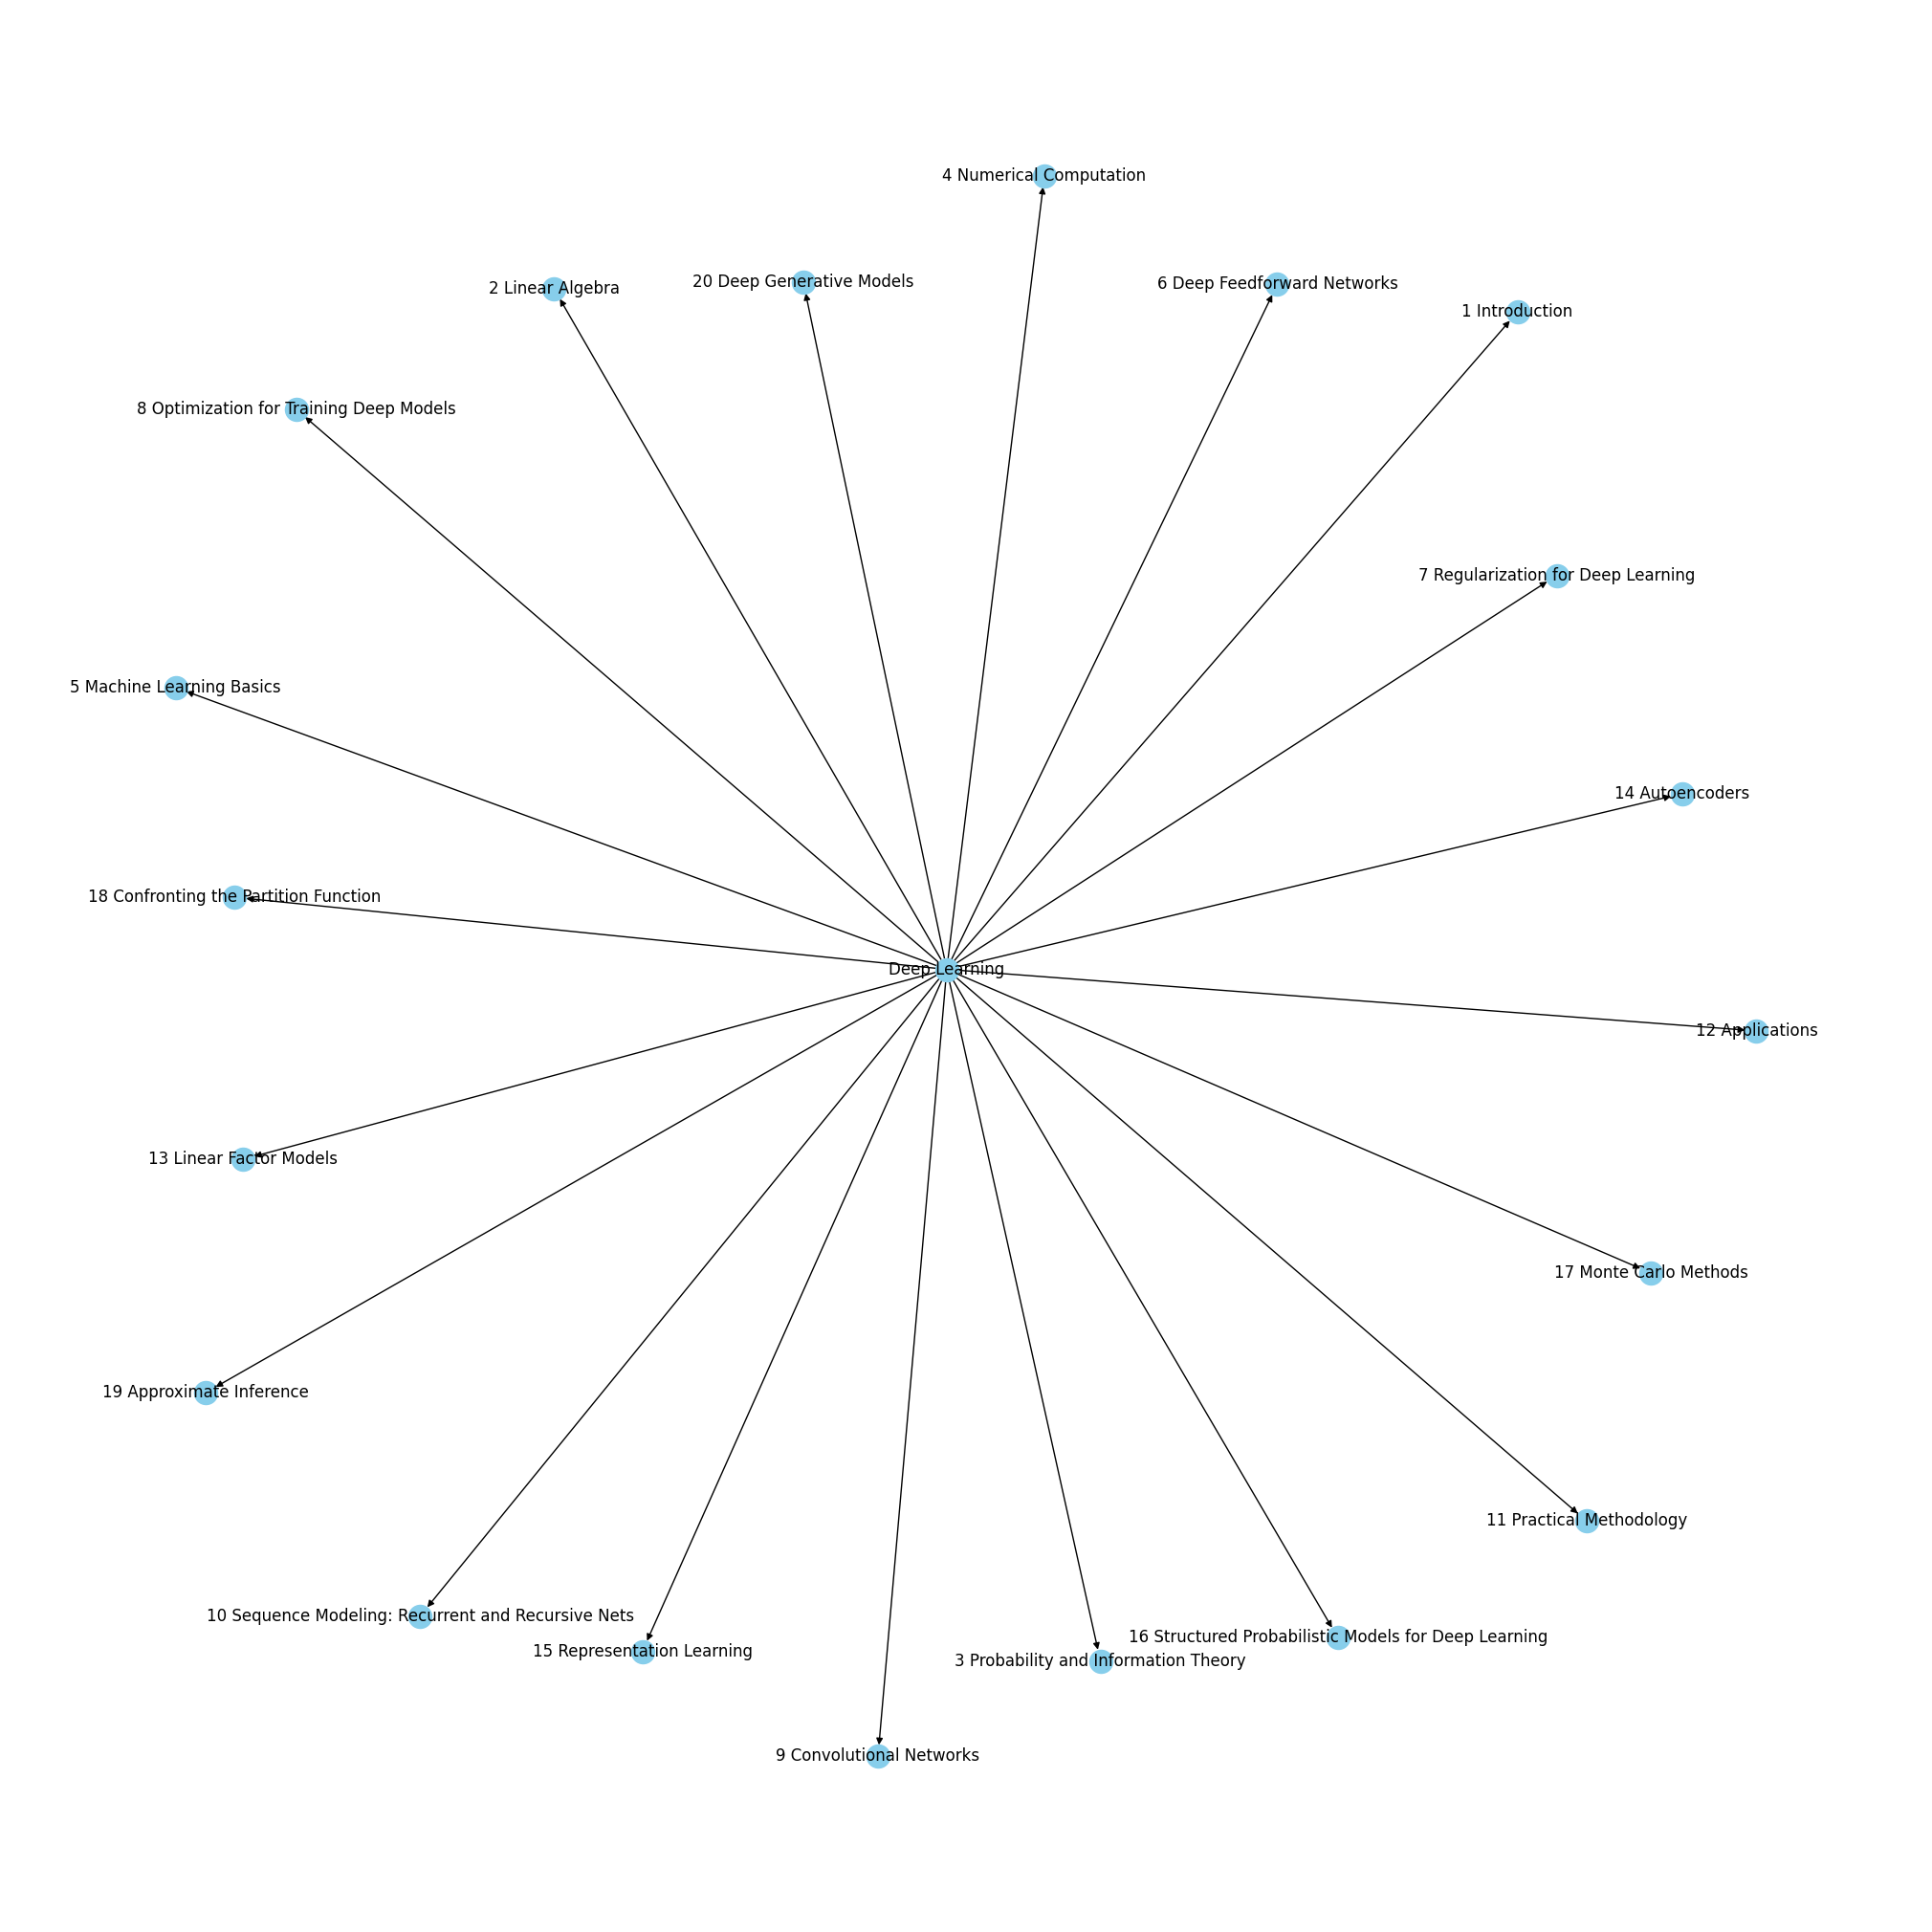

In [217]:
plt.figure(figsize=(20,20))


pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## 一些其他尝试

### N - Gram

In [218]:
# 暂时没有探索结果
# all_text = re.sub('[^A-Za-z0-9\.]+', ' ', text).lower().split(' ')
# ng1 = collections.defaultdict(int)
# ng2 = collections.defaultdict(int)
# ng3 = collections.defaultdict(int)
# ng4 = collections.defaultdict(int)
# for i, j in enumerate(all_text):
#     ng1[j] += 1
#     if i > 0: ng2[(all_text[i-1], j)] += 1
#     if i > 1: ng3[(all_text[i-2], all_text[i-1], j)] += 1
#     if i > 2: ng4[(all_text[i-3], all_text[i-2], all_text[i-1], j)] += 1

# def sort_feq(dic):
#     return sorted([(k, v) for k, v in dic.items()], key=lambda x: x[1], reverse=True)

### GPT3.5

In [219]:
def total_counts(response):
    tokens_nums = int(response["usage"]["total_tokens"])
    price = 0.003 / 1000
    cost = "{:.5f}".format(price * tokens_nums * 7.5)
    print(f"tokens: {tokens_nums}, cost: {cost}")

    return float(cost)

In [220]:
class Chat:
    def __init__(self, conversation_list=[]):
        self.conversation_list = conversation_list
        self.costs_list = []

    def show_conversation(self, msg_list):
        for msg in msg_list[-2:]:
            if msg["role"] == "user":
                pass
            else:
                message = msg["content"]
                pass
                # print(f"\U0001f47D: {message}\n")
                
    def ask(self, prompt):
        self.conversation_list.append({"role": "user", "content": prompt})
        openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-16k", messages=self.conversation_list
        )
        answer = response.choices[0].message["content"]

        self.conversation_list.append({"role": "assistant", "content": answer})
        self.show_conversation(self.conversation_list)

        cost = total_counts(response)
        self.costs_list.append(cost)
        return answer

In [221]:
NER = [
    "你是一个深度学习、机器学习、数学、计算机科学领域的实体标注专员，\
给定字符串，请找出全部深度学习、机器学习、数学、计算机科学领域的实体，\
以('entity1', 'entity2', ...)的格式返回，尽量遵循字符串中的原本表述。\
除返回结果外，不要返回任何其他内容。"
]

In [222]:
relations = "'based on', 'facet of', 'part of', 'instance of', 'subject of', 'subclass of', 'use'"

In [223]:
relation = [
    f"你是一个深度学习、机器学习、数学、计算机科学领域的关系抽取专员，\
给定关系列表({relations})，\
输入实体列表，请找出实体列表中存在关系的实体，\
并以('head', 'relation', 'tail')的格式返回所有三元组，\
请尽量不改变原实体的表述。\
除结果外，不要返回任何其他内容。\
如输入'LSTM, RNN'，返回('LSTM', 'instance of', 'RNN')"
]

In [228]:
content_dict_2 = {}
for i, (k, v) in enumerate(content_dict.items()):
    if i>=33:
        content_dict_2[k] = v

In [ ]:
for k, v in content_dict_2.items():
    for page, content in enumerate(v):
        if page % 5 == 0:
            conversation_list = [
                {
                    "role": "system",
                    "content": NER[0],
                }
            ]
            bot_ner = Chat(conversation_list)
            conversation_list = [
                {
                    "role": "system",
                    "content": relation[0],
                }
            ]

            bot_relation = Chat(conversation_list)
        answer_ner = bot_ner.ask(content)
        answer_relation = bot_relation.ask(answer_ner)
        df = pd.DataFrame(
            [[k, page, answer_ner, answer_relation]],
            columns=["section", "page", "entity", "relation"],
        )
        df.to_csv(
            os.path.join(dataDir + "/relations", f"results_gpt3_5.csv"),
            mode="a",
            header=not os.path.exists(
                os.path.join(dataDir + "/relations", f"results_gpt3_5.csv")
            ),
            index=False,
        )

tokens: 1306, cost: 0.02939
tokens: 236, cost: 0.00531
tokens: 1817, cost: 0.04088
tokens: 269, cost: 0.00605
tokens: 2539, cost: 0.05713
tokens: 304, cost: 0.00684
tokens: 3055, cost: 0.06874
tokens: 339, cost: 0.00763
tokens: 733, cost: 0.01649
tokens: 471, cost: 0.01060
tokens: 1327, cost: 0.02986
tokens: 868, cost: 0.01953
tokens: 1809, cost: 0.04070
tokens: 1159, cost: 0.02608
tokens: 2408, cost: 0.05418
tokens: 1485, cost: 0.03341
tokens: 3023, cost: 0.06802
tokens: 1685, cost: 0.03791
tokens: 580, cost: 0.01305
tokens: 236, cost: 0.00531
tokens: 1091, cost: 0.02455
tokens: 296, cost: 0.00666
tokens: 1650, cost: 0.03713
tokens: 358, cost: 0.00806
tokens: 2224, cost: 0.05004
tokens: 423, cost: 0.00952
tokens: 2646, cost: 0.05954
tokens: 497, cost: 0.01118
tokens: 853, cost: 0.01919
tokens: 538, cost: 0.01210
tokens: 796, cost: 0.01791
tokens: 565, cost: 0.01271
tokens: 1414, cost: 0.03182
tokens: 791, cost: 0.01780
tokens: 1968, cost: 0.04428
tokens: 1000, cost: 0.02250
tokens: 25